## CS4305TU Applied Machine Learning. Week 8 Assignment (Recurrent Neural Networks)

### Short-term Drinking Water Demand Forecasting with Deep Learning Techniques


Welcome to the assignment for Week 8 of your Applied Machine Learning course. In this assigment, you will be tasked with _forecasting drinking water demands (up to 24 hours ahead) in urban areas_ using Deep Learning techniques. 

<u> Background </u>

Water Distribution Systems (WDS) are networked infrastructures designed to provide drinking water to citizens and businesses. Like other critical infrastructure, modern WDS rely on digitalisation to optimize their operations in order to maximise efficiency by ensuring sustainable water management practices.

Digitalisation allows gathering and analysing sensor data to inform control strategies. For instance, accurate forecasting of _drinking water demands_ over shor-time horizons (e.g., 24 hours) can be used to better manage the operations of the pumping stations of the WDS, as well as optimizing the production of drinking water from water treatment plants.

Water demand time series are usually recorded by flow meters located at the inlet of a district. This data can then be used to develop forecasting methods, which are usually based on time series analysis techniques or, more recently, machine learning (ML). Typical input data for these models are past water demands, meteorological data, and calendar information (e.g., day of the week, holidays, important events, ...).


<br/>


 

<center><figure>
  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0377042716300565-gr6_lrg.jpg" width=600/>
<figcaption>Figure 1. Water demand forecasting: observed data vs machine learning prediction. 
    
<sub><sup>Image credits: Brentan et al. (2017), https://doi.org/10.1016/j.wroa.2019.100028 </sup></sub></figcaption>
</figure></center>

<u> Problem defintion </u>

The data for this assignment was kindly provided by the authors of [1]. The data refers to hourly measurments from a real WDS serving around 120k users (residential and industrial) of a medium-sized city of Northern Italy.

The data spans two years. You will be using the data in "Year #1" to _train_ and _validate_ different Deep Learning (DL) models based on Feed Forward Neural Networks and Recurrent Neural Networks. The performance of these models will then be evaluated on "Year #2", the _test_ dataset. Available data includes hourly average water demand in [L/s] (liters per second). Other calendar information or meteorological data is not found to provide substantial gains in predictive performances.

<b> Your goal is to build autoregressive Deep Learning models that forecast hourly water demand for the next 24 hours </b> (e.g., 24 outputs) using as input 1 week (e.g., 168 hours) of past water demand and calendar information (e.g., the _day_ boolean variable)

<u> References </u>

[1] Pacchin, E., Gagliardi, F., Alvisi, S. and Franchini, M., 2019. A comparison of short-term water demand forecasting models. Water resources management, 33(4), pp.1481-1497.


### Part 0. Exploratory data analysis

#### Link to Google Drive and Load python modules

In [1]:
# link to Google Drive to access files
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

# !ls gdrive 

In [2]:
# install tensorflow addons (hint: it has a method to stop training after a certain time has passed)
# !pip3 install tensorflow_addons

In [3]:
# generic modules
import datetime, os
import itertools
import time
import os

# append working folder
import sys
working_folder = ''
sys.path.append(working_folder)

# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import backend as K

# sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import additional helper scripts 
# (note: the file assignment_utils.py should be in the working_folder specified earlier in this cell)
import assignment_utils

#### Exploratory data analysis

In [4]:
# load water demand data
df_year1 = pd.read_csv(working_folder+'data/water_demand_Y1.txt',header=None, sep=r"\s+")
df_year2 = pd.read_csv(working_folder+'data/water_demand_Y2.txt',header=None, sep=r"\s+")

Let's visualize the typical pattern of a random day in our data. In general, these patterns show two peaks of consumption: in the morning and in the evening. Consumption is at its lowest during late night and early mornings.

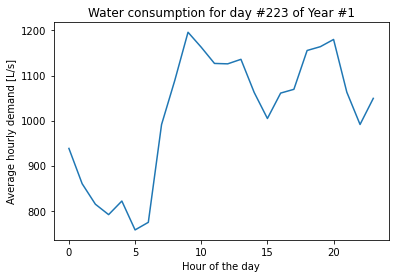

In [5]:
# plot random day
day_ix = np.random.randint(len(df_year1))
ax = df_year1.loc[day_ix].plot()
ax.set_xlabel('Hour of the day');
ax.set_ylabel('Average hourly demand [L/s]');
ax.set_title(f'Water consumption for day #{day_ix} of Year #1');

We can obtain more information on the hour-by-hour distribution of the water demand by using boxplots. These are computed across all days for each hour of the day. By plotting the distribution for both years we see that <u> consumptions increased in Year #2 </u>. This also emerges from the overall average (red line).

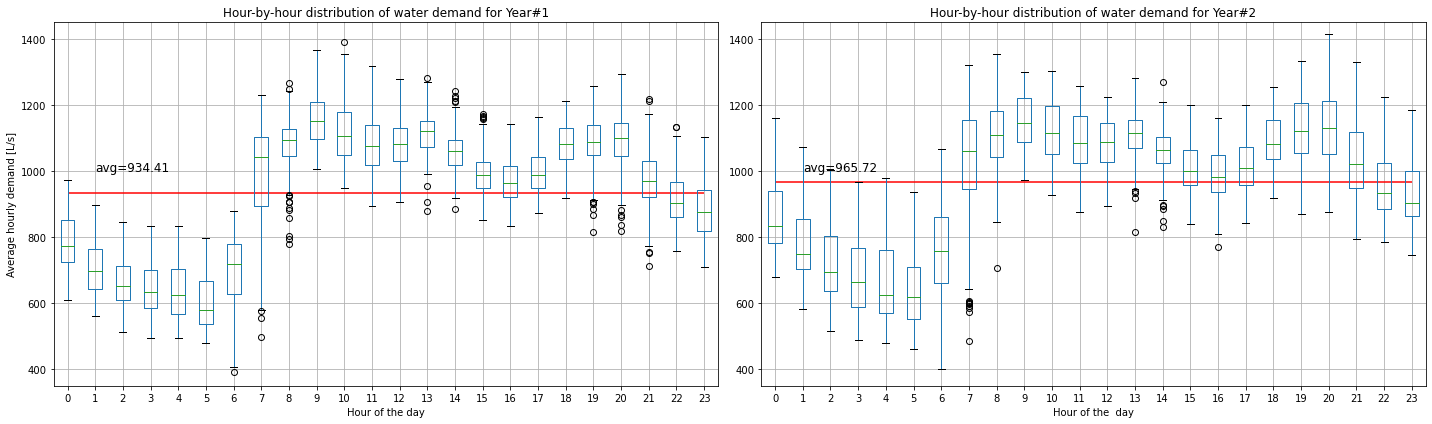

In [6]:
# plot hourly water demand distributions across all days

# year 1
f, axes = plt.subplots(1,2,figsize=(20,6))
df_year1.boxplot(ax=axes[0])
axes[0].set_xlabel('Hour of the day');
axes[0].set_ylabel('Average hourly demand [L/s]');
axes[0].set_title('Hour-by-hour distribution of water demand for Year#1');
axes[0].set_ylim([350,1450])

avg_year1 = df_year1.values.reshape(-1).mean()
axes[0].hlines(avg_year1,1,24, colors='r')
axes[0].text(2, 1000, f'avg={avg_year1:.2f}', fontsize=12)

# year 2
df_year2.boxplot(ax=axes[1])
axes[1].set_xlabel('Hour of the  day');
# axes[1].set_ylabel('Average hourly demand [L/s]');
axes[1].set_title('Hour-by-hour distribution of water demand for Year#2');
axes[1].set_ylim([350,1450])

avg_year2 = df_year2.values.reshape(-1).mean()
axes[1].hlines(avg_year2,1,24, colors='r')
axes[1].text(2, 1000, f'avg={avg_year2:.2f}', fontsize=12)

f.tight_layout()

#### Creation of sequence-to-sequence modeling dataset and data normalization

We now create the sequence datasets for _training_, _validating_ and _testing_ our DL methods. We will start by only using past water demands. These datasets will be created by calling one of the helper functions in the ```assignment_utils``` module. We first create the sequences for Year \#1, which will be used for training and validation.

In [7]:
T = 168 # number of time steps to use for prediction (168 hours = 1 week)
H = 24  # number of time steps to predict (24 hours)
X,Y=assignment_utils.create_sequences(df_year1.values.reshape(-1),T=T,H=H)
print(X.shape)
print(Y.shape)

(8568, 168)
(8568, 24)


As you can see, each input-ouput pair is made of: 1) an input sequence of 168 hours (e.g., 1 week) and 2) an output sequence of 24 hours.

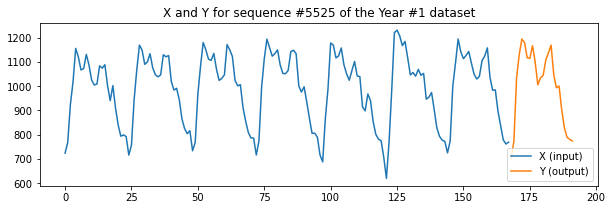

In [8]:
random_ix = np.random.choice(X.shape[0])
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X[random_ix], label='X (input)')
ax.plot(np.arange(T,T+H),Y[random_ix], label = 'Y (output)')
ax.set_title(f'X and Y for sequence #{random_ix} of the Year #1 dataset');
ax.legend();

These sequences are not normalized yet, and we need to split them into training and validation. We first perform the latter task and then we use ```scale_sequences``` to perform the scaling. Is important to use the scaler "fitted" for the training dataset to scale tha validation dataset and then the test dataset (Year \#2). Since the input and output variables are both water demand, we only need to fit one scaler. ```scale_sequences``` recognize whether to fit a scaler or use an existing one based on the arguments it receives when called.

In [9]:
# we use 15% of Year #1 for validation; we shuffle the sequences; 
# we keep track of indexes of train and validation.
X_train, X_val, Y_train, Y_val, ix_train, ix_val = train_test_split(
    X, Y, np.arange(X.shape[0]), test_size=0.15, shuffle=True, random_state=42)
print(f"X_tra.shape: {X_train.shape}, Y_tra.shape: {Y_train.shape}")
print(f"X_val.shape: {X_val.shape}, Y_val.shape: {Y_val.shape}")

X_tra.shape: (7282, 168), Y_tra.shape: (7282, 24)
X_val.shape: (1286, 168), Y_val.shape: (1286, 24)


Let's plot a random sequence from the training dataset

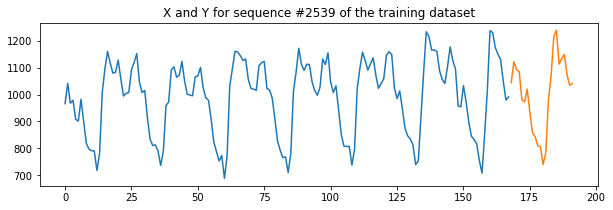

In [10]:
random_ix = np.random.choice(X_train.shape[0])
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X_train[random_ix], label='Xtra')
ax.plot(np.arange(T,T+H),Y_train[random_ix], label = 'Ytra')
ax.set_title(f'X and Y for sequence #{random_ix} of the training dataset');

Now we scale all data. Remember: <u>you "fit" the scaler using training data </u>; when you develop your machine learning models, you have to assume that you have no information on validation and test data.

In [11]:
X_train, scaler = assignment_utils.scale_sequences(X_train, scaler_type='minmax')
Y_train, _ = assignment_utils.scale_sequences(Y_train, scaler)
X_val, _   = assignment_utils.scale_sequences(X_val, scaler)
Y_val, _   = assignment_utils.scale_sequences(Y_val, scaler)

As you can see, the sequences before and after normalization look the same, but the ranges are different.

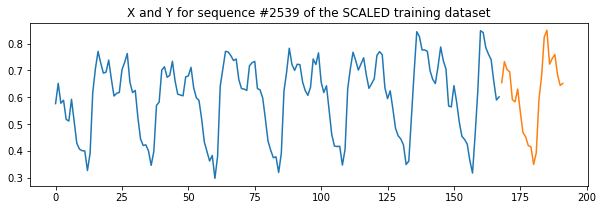

In [12]:
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X_train[random_ix], label='Xtra')
ax.plot(np.arange(T,T+H),Y_train[random_ix], label = 'Ytra')
ax.set_title(f'X and Y for sequence #{random_ix} of the SCALED training dataset');

Before proceeding with the assignment, we now create scaled sequences for the test dataset.

In [13]:
# create
X_test, Y_test = assignment_utils.create_sequences(df_year2.values.reshape(-1), T=T, H=H)
print(X_test.shape)
print(Y_test.shape)

# normalize
X_test, _ = assignment_utils.scale_sequences(X_test, scaler)
Y_test, _ = assignment_utils.scale_sequences(Y_test, scaler)

(8568, 168)
(8568, 24)


### <u>BEGINNING OF ASSIGNMENT</u>

#### Part 1. Train a Feed-forward Neural Network that will be used as benchmark.

You are asked to train several FNNs architectures (between 10 and 20) to develop a good benchmark for the *water demand forecasting problem*.

_Instructions_
- Try single hidden layer as well as double hidden layer FNNs;
- Try different activation functions for the hidden layer (e.g., ```ReLU```, ```tanh```); keep the output activation function ```linear```;
- Limit the total number of neurons in each layer to 100;
- Use ```dropout``` and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 10 minutes for each model;
- Save all models (e.g., using the model checkpoint callback);
- Use the ```Adam``` optimizer, and set learning rate to 0.005;
- Use a batch size of 32.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the benchmark architecture and motivate why.
- Plot the training/validation history of the selected FNN architecture

In [14]:
# Function for model creation
def FNNmodel(n_hidden_neurons=10, n_hidden_layers=2, activation='sigmoid', dropout_rate=0.1):
  # input layer
  i = Input(shape=(T,)) 

  # hidden layers
  for hidden_layer in range(n_hidden_layers):
    if hidden_layer == 0:
      x = Dense(n_hidden_neurons, activation=activation, name='Hidden_layer'+str(hidden_layer+1))(i)
    else:
      x = Dense(n_hidden_neurons, activation=activation, name='Hidden_layer'+str(hidden_layer+1))(x)
    x = Dropout(dropout_rate)(x)
    
  # output layer
  x = Dense(H, activation='linear', name='Output')(x)  

  # configure model
  model = Model(i, x)
  return model

def get_trainable_params(model):
    # this function returns the number of trainable parameters in a Keras model
    return np.sum([K.count_params(w) for w in model.trainable_weights]).astype(int)

# model = FNNmodel(n_hidden_neurons=10, n_hidden_layers=2, activation='sigmoid', dropout_rate=0.1)
# model.summary()

In [15]:
# create model combinations (using itertools product)
ANN_type = ['FNN']
neurons = [50, 75, 100]
layers = [1, 2]
activation = ['sigmoid', 'tanh', 'relu']
dropout_rate = [0.25]
learning_rate = [0.0005]
batch_size = [32]

input_columns = ['ann_type', 'neurons', 'layers', 'activation', 'dropout_rate', 'learning_rate', 'batch_size']

all_combinations = list(itertools.product(*[ANN_type, neurons, layers, activation, dropout_rate, learning_rate, batch_size]))
display(pd.DataFrame(data=all_combinations, columns=input_columns))

,ann_type,neurons,layers,activation,dropout_rate,learning_rate,batch_size
0,FNN,50,1,sigmoid,0.25,0.0005,32
1,FNN,50,1,tanh,0.25,0.0005,32
2,FNN,50,1,relu,0.25,0.0005,32
3,FNN,50,2,sigmoid,0.25,0.0005,32
4,FNN,50,2,tanh,0.25,0.0005,32
5,FNN,50,2,relu,0.25,0.0005,32
6,FNN,75,1,sigmoid,0.25,0.0005,32
7,FNN,75,1,tanh,0.25,0.0005,32
8,FNN,75,1,relu,0.25,0.0005,32
9,FNN,75,2,sigmoid,0.25,0.0005,32


In [16]:
# result df 
results_columns = ['model_name', 'tr_loss', 'val_loss', 'tr_mae', 'val_mae', 'elapsed_time', 'trainable_params']
res_df_fnn = pd.DataFrame(index=np.arange(len(all_combinations)), columns=input_columns+results_columns)

rs = [] # histories

# create folder to store model parameters
if not os.path.exists(working_folder+'FNN_Model_parameters'):
  os.makedirs(working_folder+'FNN_Model_parameters')

for i, combination in enumerate(all_combinations):
  # extract parameters and create model name  
  ANN_type, neurons, layers, activation, dropout_rate, learning_rate, batch_size = combination
  model_name = f"{ANN_type}_neurons={neurons}_layers={layers}_activation={activation}_dropout={dropout_rate}_lr={learning_rate}_bsize={batch_size}"
  # store in res_df 
  res_df_fnn.loc[i, input_columns] = combination
  res_df_fnn.loc[i, 'model_name'] = model_name

  # call backs
  earlyStopping   = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-6, mode='auto')
  modelCheckpoint = ModelCheckpoint(f'{working_folder}FNN_Model_parameters/{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
  timeStopping    = tfa.callbacks.TimeStopping(seconds=10*60, verbose=1)  
  callbacks = [earlyStopping, modelCheckpoint, timeStopping]

  # create model
  model = FNNmodel(neurons, layers, activation, dropout_rate)

  # compile
  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

  # echo screen
  print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')

  # train
  start_time = time.time()
  r = model.fit(X_train, Y_train,epochs=200, validation_data=(X_val, Y_val), callbacks=callbacks, verbose=0, batch_size=batch_size)
  
  # append history
  rs.append(r)
  # store results
  res_df_fnn.loc[i, 'elapsed_time'] = time.time() - start_time
  best_ix = np.array(r.history['val_loss']).argmin()
  res_df_fnn.loc[i, ['tr_loss', 'val_loss', 'tr_mae', 'val_mae']] = [r.history['loss'][best_ix], r.history['val_loss'][best_ix],
                                                                     r.history['mean_absolute_error'][best_ix],r. history['val_mean_absolute_error'][best_ix]]     
  res_df_fnn.loc[i, 'trainable_params'] = get_trainable_params(model)

  print(res_df_fnn.loc[i,['elapsed_time','val_loss','val_mae', 'tr_mae']])

2021-10-21 21:07:12.781539: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training FNN_neurons=50_layers=1_activation=sigmoid_dropout=0.25_lr=0.0005_bsize=32, #1 of 18


2021-10-21 21:07:13.090497: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


elapsed_time    56.713095
val_loss         0.002814
val_mae          0.039505
tr_mae           0.055935
Name: 0, dtype: object
Training FNN_neurons=50_layers=1_activation=tanh_dropout=0.25_lr=0.0005_bsize=32, #2 of 18
elapsed_time    51.850875
val_loss         0.002111
val_mae          0.033428
tr_mae           0.048308
Name: 1, dtype: object
Training FNN_neurons=50_layers=1_activation=relu_dropout=0.25_lr=0.0005_bsize=32, #3 of 18
elapsed_time    82.385719
val_loss         0.002905
val_mae          0.040486
tr_mae           0.061134
Name: 2, dtype: object
Training FNN_neurons=50_layers=2_activation=sigmoid_dropout=0.25_lr=0.0005_bsize=32, #4 of 18
elapsed_time    65.181219
val_loss         0.003567
val_mae          0.045533
tr_mae           0.059987
Name: 3, dtype: object
Training FNN_neurons=50_layers=2_activation=tanh_dropout=0.25_lr=0.0005_bsize=32, #5 of 18
elapsed_time    57.77967
val_loss        0.002585
val_mae         0.038132
tr_mae          0.055076
Name: 4, dtype: object
Tr

In [17]:
res_df_fnn.sort_values(by='val_loss')

,ann_type,neurons,layers,activation,dropout_rate,learning_rate,batch_size,model_name,tr_loss,val_loss,tr_mae,val_mae,elapsed_time,trainable_params
13,FNN,100,1,tanh,0.25,0.0005,32,FNN_neurons=100_layers=1_activation=tanh_dropo...,0.002946,0.001856,0.041526,0.031009,52.685965,19324
7,FNN,75,1,tanh,0.25,0.0005,32,FNN_neurons=75_layers=1_activation=tanh_dropou...,0.003278,0.001923,0.043945,0.031799,69.460087,14499
16,FNN,100,2,tanh,0.25,0.0005,32,FNN_neurons=100_layers=2_activation=tanh_dropo...,0.003647,0.002092,0.04687,0.033767,62.845173,29424
1,FNN,50,1,tanh,0.25,0.0005,32,FNN_neurons=50_layers=1_activation=tanh_dropou...,0.003913,0.002111,0.048308,0.033428,51.850875,9674
12,FNN,100,1,sigmoid,0.25,0.0005,32,FNN_neurons=100_layers=1_activation=sigmoid_dr...,0.003878,0.002143,0.047445,0.033992,59.056331,19324
17,FNN,100,2,relu,0.25,0.0005,32,FNN_neurons=100_layers=2_activation=relu_dropo...,0.004175,0.002207,0.049574,0.035071,60.463252,29424
10,FNN,75,2,tanh,0.25,0.0005,32,FNN_neurons=75_layers=2_activation=tanh_dropou...,0.004118,0.00229,0.049932,0.035561,82.895824,20199
14,FNN,100,1,relu,0.25,0.0005,32,FNN_neurons=100_layers=1_activation=relu_dropo...,0.004996,0.002343,0.053958,0.035954,50.478305,19324
6,FNN,75,1,sigmoid,0.25,0.0005,32,FNN_neurons=75_layers=1_activation=sigmoid_dro...,0.004447,0.002365,0.050908,0.035861,56.201074,14499
15,FNN,100,2,sigmoid,0.25,0.0005,32,FNN_neurons=100_layers=2_activation=sigmoid_dr...,0.004265,0.002425,0.049805,0.036719,62.325118,29424


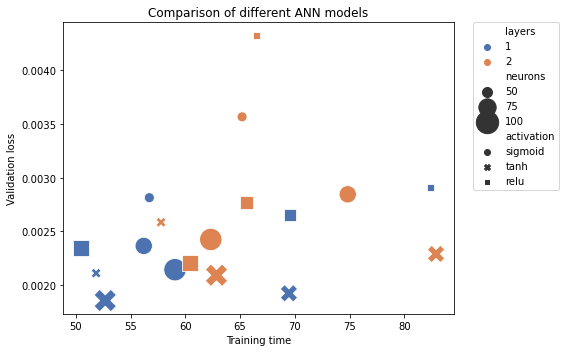

In [24]:
f, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(data=res_df_fnn, x="elapsed_time", y="val_loss", hue="layers", style="activation", size="neurons", 
                    sizes=(100, 500), ax=ax, palette='deep')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Comparison of different ANN models')
ax.set_xlabel('Training time')
ax.set_ylabel('Validation loss')

f.tight_layout()
plt.show()

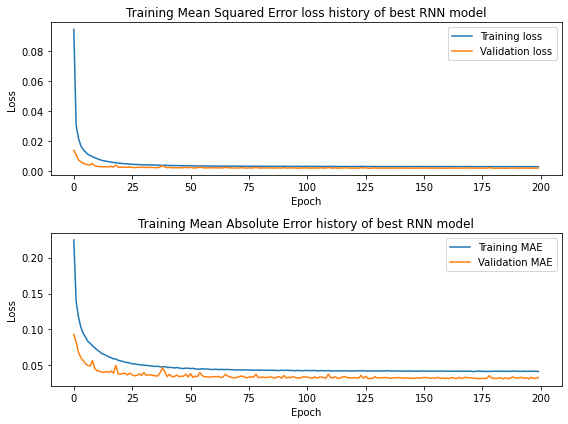

In [26]:
# obtain best performing model
best_model_ix = res_df_fnn['val_loss'].astype(float).idxmin()

f, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(rs[best_model_ix].history['loss'], label='Training MSE loss')
axes[0].plot(rs[best_model_ix].history['val_loss'], label='Validation MSE loss')
axes[0].set_title('Training Mean Squared Error loss history of best RNN model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(rs[best_model_ix].history['mean_absolute_error'], label='Training MAE')
axes[1].plot(rs[best_model_ix].history['val_mean_absolute_error'], label='Validation MAE')
axes[1].set_title('Training Mean Absolute Error history of best RNN model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

f.tight_layout()
plt.show()

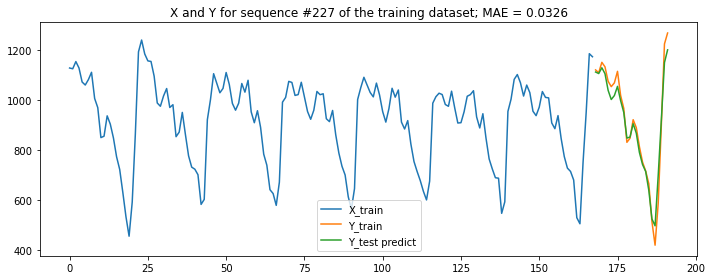

In [37]:
### Compare model predictions to true output; tested on test data set
best_model_ix = res_df_fnn['val_loss'].astype(float).idxmin()

# Obtain best trained model
neurons, layers, activation, dropout_rate, model_name = res_df_fnn.loc[best_model_ix, ['neurons', 'layers', 'activation', 'dropout_rate', 'model_name']]
best_model = FNNmodel(neurons, layers, activation, dropout_rate)                     # define model architecture
best_model.load_weights(f'{working_folder}FNN_Model_parameters/{model_name}.hdf5')   # load trained model parameters into model
Y_test_pred = best_model.predict(X_test)                                             # predict output on test data set

# Plot predictions
random_ix = np.random.choice(X_test.shape[0])
fig, ax = plt.subplots(1,figsize=(10,4))  
ax.plot(np.arange(T), scaler.inverse_transform(X_test[random_ix].reshape(-1, 1)), label='X_train')
ax.plot(np.arange(T,T+H), scaler.inverse_transform(Y_test[random_ix].reshape(-1, 1)), label='Y_train')
ax.plot(np.arange(T,T+H), scaler.inverse_transform(Y_test_pred[random_ix].reshape(-1, 1)), label='Y_test predict')
ax.legend()
ax.set_title(f'X and Y for sequence #{random_ix} of the training dataset; MAE = {mean_absolute_error(Y_test[random_ix], Y_test_pred[random_ix]).round(4)}')

fig.tight_layout()
plt.show()

#### Part 2. Train multiple Recurrent Neural Networks architectures.

You are asked to train several RNNs architectures (between 10 and 20) to identify a suitable model for *water demand forecasting problem*.

_Instructions_
- Try SimpleRNN as well as LSTM;
- You can also try GRU and/or double-layered RNNs;
- Try different activation functions for the hidden layer (e.g., ```ReLU```, ```tanh```); keep the output activation function ```linear```
- Limit the total number of neurons to 100 for layer;
- Use dropout and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 10 minutes for each model;
- Save all models (e.g., using the model checkpoint callback) 
- Use the ```Adam``` optimizer, and set learning rate to 0.005;
- Use a batch size of 32.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the most promising architecture and motivate why. 
- Did SimpleRNN units largely underperform more advanced RNNs such as LSTM? If so, why? If not, what can be the reason?
- Plot the training/validation history of the selected RNN architecture;



In [38]:
# Function for model creation
def RNNmodel(n_hidden_neurons=10, n_hidden_layers=2, activation='tanh', cell_type='LSTM', dropout_rate=0.2):
  deep = True if n_hidden_layers >= 2 else False
  # input layer
  i = Input(shape=(T,1))
  
  # hidden layers
  for hidden_layer in range(n_hidden_layers):
    if cell_type == 'SimpleRNN':
      if hidden_layer == 0:
        x = SimpleRNN(n_hidden_neurons, activation=activation, name='SimpleRNN'+str(hidden_layer+1),
                          return_sequences=True if deep else False)(i)  # return_sequence must be set to True when placed before another recurrent layer
      else:
        x = SimpleRNN(n_hidden_neurons, activation=activation, name='SimpleRNN'+str(hidden_layer+1), 
                          return_sequences=True if (deep and hidden_layer != n_hidden_layers-1) else False)(x)
      x = Dropout(dropout_rate)(x)

    elif cell_type == 'LSTM':
      if hidden_layer == 0:
        x = LSTM(n_hidden_neurons, activation=activation, name='LSTM'+str(hidden_layer+1), 
                      return_sequences=True if deep else False)(i)
      else:
        x = LSTM(n_hidden_neurons, activation=activation, name='LSTM'+str(hidden_layer+1),
                      return_sequences=True if (deep and hidden_layer != n_hidden_layers-1) else False)(x)
      x = Dropout(dropout_rate)(x)

    else:
      raise Exception("Error: Cell type not recognized! Choose between 'SimpleRNN','LSTM', or 'GRU'.")    

  # output layer
  x = Dense(H, activation='linear', name='Output')(x)

  # configure model
  model = Model(i,x)
  return model

def get_trainable_params(model):
    # this function returns the number of trainable parameters in a Keras model
    return np.sum([K.count_params(w) for w in model.trainable_weights]).astype(int)
  
# model = RNNmodel(n_hidden_neurons=50, n_hidden_layers=2, activation='sigmoid', cell_type='SimpleRNN',)
# model.summary()

In [39]:
# create model combinations (using itertools product)
ANN_type = ['SimpleRNN', 'LSTM']
neurons = [50, 100]
layers = [1, 2]
activation = ['sigmoid', 'tanh', 'relu']
dropout_rate = [0.25]
learning_rate = [0.0005]
batch_size = [32]

input_columns = ['ann_type', 'neurons', 'layers', 'activation', 'dropout_rate', 'learning_rate', 'batch_size']

all_combinations = list(itertools.product(*[ANN_type, neurons, layers, activation, dropout_rate, learning_rate, batch_size]))
display(pd.DataFrame(data=all_combinations, columns=input_columns))

,ann_type,neurons,layers,activation,dropout_rate,learning_rate,batch_size
0,SimpleRNN,50,1,sigmoid,0.25,0.0005,32
1,SimpleRNN,50,1,tanh,0.25,0.0005,32
2,SimpleRNN,50,1,relu,0.25,0.0005,32
3,SimpleRNN,50,2,sigmoid,0.25,0.0005,32
4,SimpleRNN,50,2,tanh,0.25,0.0005,32
5,SimpleRNN,50,2,relu,0.25,0.0005,32
6,SimpleRNN,100,1,sigmoid,0.25,0.0005,32
7,SimpleRNN,100,1,tanh,0.25,0.0005,32
8,SimpleRNN,100,1,relu,0.25,0.0005,32
9,SimpleRNN,100,2,sigmoid,0.25,0.0005,32


In [40]:
# result df 
results_columns = ['model_name', 'tr_loss', 'val_loss', 'tr_mae', 'val_mae', 'elapsed_time', 'trainable_params']
res_df_rnn = pd.DataFrame(index=np.arange(len(all_combinations)), columns=input_columns+results_columns)

rs_2 = [] # histories

# create folder to store model parameters
if not os.path.exists(working_folder+'RNN_Model_parameters'):
  os.makedirs(working_folder+'RNN_Model_parameters')

for i, combination in enumerate(all_combinations):
  # extract parameters and create model name  
  ANN_type, neurons, layers, activation, dropout_rate, learning_rate, batch_size = combination
  model_name = f"{ANN_type}_neurons={neurons}_layers={layers}_activation={activation}_dropout={dropout_rate}_lr={learning_rate}_bsize={batch_size}"
  # store in res_df 
  res_df_rnn.loc[i, input_columns] = combination
  res_df_rnn.loc[i, 'model_name'] = model_name

  # call backs
  earlyStopping   = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-6, mode='auto')
  modelCheckpoint = ModelCheckpoint(f'{working_folder}RNN_Model_parameters/{model_name}.hdf5', save_best_only=True, monitor='val_loss', mode='auto', save_weights_only=True)
  timeStopping    = tfa.callbacks.TimeStopping(seconds=10*60, verbose=1)  
  callbacks = [earlyStopping, modelCheckpoint, timeStopping]

  # create model
  model = RNNmodel(neurons, layers, activation, ANN_type, dropout_rate)

  # compile
  model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

  # echo screen
  print(f'Training {model_name}, #{i+1} of {len(all_combinations)}')

  # train
  start_time = time.time()
  r = model.fit(X_train, Y_train,epochs=200, validation_data=(X_val, Y_val), callbacks=callbacks, verbose=0, batch_size=batch_size)
  
  # append history
  rs_2.append(r)
  # store results
  res_df_rnn.loc[i, 'elapsed_time'] = time.time() - start_time
  best_ix = np.array(r.history['val_loss']).argmin()
  res_df_rnn.loc[i, ['tr_loss', 'val_loss', 'tr_mae', 'val_mae']] = [r.history['loss'][best_ix], r.history['val_loss'][best_ix],
                                                                     r.history['mean_absolute_error'][best_ix],r. history['val_mean_absolute_error'][best_ix]]     
  res_df_rnn.loc[i, 'trainable_params'] = get_trainable_params(model)

  print(res_df_rnn.loc[i,['elapsed_time','val_loss','val_mae', 'tr_mae']])

Training SimpleRNN_neurons=50_layers=1_activation=sigmoid_dropout=0.25_lr=0.0005_bsize=32, #1 of 24
Timed stopping at epoch 85 after training for 0:10:00
elapsed_time    601.541395
val_loss          0.005034
val_mae           0.054289
tr_mae             0.06473
Name: 0, dtype: object
Training SimpleRNN_neurons=50_layers=1_activation=tanh_dropout=0.25_lr=0.0005_bsize=32, #2 of 24
Timed stopping at epoch 85 after training for 0:10:00
elapsed_time    601.784549
val_loss          0.002491
val_mae           0.037333
tr_mae            0.051078
Name: 1, dtype: object
Training SimpleRNN_neurons=50_layers=1_activation=relu_dropout=0.25_lr=0.0005_bsize=32, #3 of 24
Timed stopping at epoch 90 after training for 0:10:00
elapsed_time    604.65392
val_loss         0.003062
val_mae          0.041893
tr_mae           0.058857
Name: 2, dtype: object
Training SimpleRNN_neurons=50_layers=2_activation=sigmoid_dropout=0.25_lr=0.0005_bsize=32, #4 of 24
Timed stopping at epoch 44 after training for 0:10:00
e

In [ ]:
res_df_rnn.sort_values(by='val_loss')

In [ ]:
f, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(data=res_df_rnn, x="elapsed_time", y="val_loss", hue="layers", style="activation", size="neurons", 
                    sizes=(30, 500), ax=ax, palette='deep')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Comparison of different ANN models')
ax.set_xlabel('Training time')
ax.set_ylabel('Validation loss')

f.tight_layout()
plt.show()

In [ ]:
# obtain best performing model
best_model_ix = res_df_rnn['val_loss'].astype(float).idxmin()

f, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(rs_2[best_model_ix].history['loss'], label='Training MSE loss')
axes[0].plot(rs_2[best_model_ix].history['val_loss'], label='Validation MSE loss')
axes[0].set_title('Training Mean Squared Error loss history of best RNN model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(rs_2[best_model_ix].history['mean_absolute_error'], label='Training MAE')
axes[1].plot(rs_2[best_model_ix].history['val_mean_absolute_error'], label='Validation MAE')
axes[1].set_title('Training Mean Absolute Error history of best RNN model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

f.tight_layout()
plt.show()

In [ ]:
# Compare model predictions to true output; tested on test data set
best_model_ix = res_df_rnn['val_loss'].astype(float).idxmin()

# Obtain best trained model
neurons, layers, activation, dropout_rate, model_name = res_df_rnn.loc[best_model_ix, ['neurons', 'layers', 'activation', 'dropout_rate', 'model_name']]
model = RNNmodel(neurons, layers, activation, ANN_type, dropout_rate)           # define model architecture
model.load_weights(f'{working_folder}RNN_Model_parameters/{model_name}.hdf5')   # load trained model parameters into model
Y_test_pred = model.predict(X_test)                                             # predict output on test data set

# Plot predictions
random_ix = np.random.choice(X_test.shape[0])
fig, ax = plt.subplots(1,figsize=(10,4))  
ax.plot(np.arange(T), scaler.inverse_transform(X_test[random_ix].reshape(-1, 1)), label='X_train')
ax.plot(np.arange(T,T+H), scaler.inverse_transform(Y_test[random_ix].reshape(-1, 1)), label='Y_train')
ax.plot(np.arange(T,T+H), scaler.inverse_transform(Y_test_pred[random_ix].reshape(-1, 1)), label='Y_test predict')
ax.legend()
ax.set_title(f'X and Y for sequence #{random_ix} of the training dataset; MAE = {mean_absolute_error(Y_test[random_ix], Y_test_pred[random_ix]).round(4)}')

fig.tight_layout()
plt.show()

#### Part 3. <u> Compare best FNN and RNN models </u>.

You will now compare the results and predictions of the best FNN and RNN models on the test dataset.

_Instructions_
- Load the best FNN and RNN models.
- Use the models to predict water demands for the training, validation and test dataset.
- Visually compare the output of the two models on the test dataset. This can be done by plotting predictions and prediction errors for 5 randomly selected sequences of the test dataset.
- Quantitatively compare the two models by computing the ```mean_absolute_error``` for the training, validation and test dataset.
- <u> Remember to scale back predictions and observations using the ```inverse_transform``` method of the scaler.</u>

_Questions_
- Do RNNs outperform FNNs? How did you compare them?
- How does the test ```mean_absolute_error``` compare to that measured during training and validation? Do you think the models might be overfitting?
- If so, do you think it happens because of model limitations or because of the datasets used?
